In [1]:
import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state, geo_search
from ACS_data import colname_mask
import re
import pickle
import requests
pd.set_option('display.max_columns', None)

In [2]:
class endpoint_graph():
    def __init__(self, gdict=None):
        if gdict==None:
            gdict = []
        self.gdict = gdict

    
        
        

In [3]:
# http://jeffreyfossett.com/2017/05/07/querying-usa-spending-python.html

# goal of this function is to get
# 1. Covid only relief spending (def_codes)
# 2. Filtered by department/agency
# 3. In a dream world we have businesses and hospital per county as well. 
#
# Can't get from api/v2/disaster need to go through api/v2/search

def post_usaspending_pages(query='agency', just_health=False):
    
    query_dict = {'agency':'/api/v2/disaster/agency/spending/',
                 'cfda':'/api/v2/disaster/cfda/spending/', # v long
                 'fed_acct':'/api/v2/disaster/federal_account/spending/',
                 'search_geo':'/api/v2/search/spending_by_geography/',
                 'toptier':'/api/v2/references/toptier_agencies/',
                 'dis_geo':'/api/v2/disaster/spending_by_geography/'}
    
    q = query_dict[query]

    # initialization
    has_next_page = True
    page = 1
    output = []

    while has_next_page:
        payload =  {
      "filter": {
          "def_codes": ["L", "M", "N", "O", "P", "U"]
      },
      "geo_layer": "county",
     # "geo_layer_filters": ["NE", "WY", "CO", "IA", "IL", "MI", "IN", "TX"],
      "scope": "recipient_location",
      "spending_type": "total",
      "pagination": {
                  "limit": 10,
                  "page": page,
                  "sort": "award_count",
                  "order": "desc"
              }
    }


        r = requests.post('https://api.usaspending.gov'+q, json=payload)
        rjson = r.json()
        output+= rjson['results']
        has_next_page = rjson['page_metadata']['hasNext']
        page+=1
        print(r.status_code, page)
    return output

def post_usaspending(query='agency', just_health=False):
    
    query_dict = {
                 'cfda':'/api/v2/disaster/cfda/spending/', # v long
                 'fed_acct':'/api/v2/disaster/federal_account/spending/',
                 'search_geo':'/api/v2/search/spending_by_geography/',
                 'toptier':'/api/v2/references/toptier_agencies/',
                 'dis_geo':'/api/v2/disaster/spending_by_geography/'}
    
    q = query_dict[query]

    # initialization
    has_next_page = True
    page = 1
    output = []

    payload =  {
  "filter": {
      "def_codes": ["L", "M", "N", "O", "P", "U"]
  },
  "geo_layer": "county",
 # "geo_layer_filters": ["NE", "WY", "CO", "IA", "IL", "MI", "IN", "TX"],
  "scope": "recipient_location",
  "spending_type": "obligation"
}


    r = requests.post('https://api.usaspending.gov'+q, json=payload)
    rjson = r.json()
    output+= rjson['results']
    #has_next_page = rjson['page_metadata']['hasNext']
    #page+=1
    print(r.status_code)
    return output

In [4]:
has_next_page = True
page = 1
output = []

#while has_next_page:
payload = {
      "filter": {
          "def_codes": ["L", "M", "N", "O", "P", "U"],
          "award_type_codes": ["02", "03", "04", "05", "07", "08", "10", "06", "09", "11", "A", "B", "C", "D", "IDV_A", "IDV_B", "IDV_B_A", "IDV_B_B", "IDV_B_C", "IDV_C", "IDV_D", "IDV_E"]
      },
    #  "pagination": {
    #      "limit": 10,
    #      "page": page,
    #      "sort": "award_count",
    #      "order": "desc"
    #  },
      "spending_type": "total"
  }


r= requests.post('https://api.usaspending.gov/api/v2/disaster/agency/loans/', json=payload)
rjson = r.json()
#has_next_page = rjson['page_metadata']['hasNext']
#page+=1
output+=rjson#['results']


In [5]:
output

['detail']

In [47]:
post_usaspending('dis_geo')

200


[{'amount': 32848306171.16,
  'display_name': 'Los Angeles',
  'shape_code': '06037',
  'population': 10039107,
  'per_capita': 3272.03,
  'award_count': 747836},
 {'amount': 8909569577.95,
  'display_name': 'Miami-Dade',
  'shape_code': '12086',
  'population': 2716940,
  'per_capita': 3279.27,
  'award_count': 423598},
 {'amount': 27132210710.36,
  'display_name': 'Cook',
  'shape_code': '17031',
  'population': 5150233,
  'per_capita': 5268.15,
  'award_count': 398169},
 {'amount': 13480970276.03,
  'display_name': 'Harris',
  'shape_code': '48201',
  'population': 4713325,
  'per_capita': 2860.18,
  'award_count': 280146},
 {'amount': 6607328901.56,
  'display_name': 'Broward',
  'shape_code': '12011',
  'population': 1952778,
  'per_capita': 3383.55,
  'award_count': 226534},
 {'amount': 11492189568.89,
  'display_name': 'Orange',
  'shape_code': '06059',
  'population': 3175692,
  'per_capita': 3618.8,
  'award_count': 219404},
 {'amount': 20469118325.18,
  'display_name': 'New Y

In [5]:
response = post_usaspending_pages()
response

agencies = ['Department of Labor', 'Department of Veterans Affairs', 'Department of Transportation',
           'Department of Health and Human Services', 'Department of Education', 'Department of Housing and Urban Development']

agency_dict = {}
for i in response:
    if i['description'] in agencies:
        agency_dict[i['description']] = {'id':i['id'], 'code':i['code']}
agency_dict

200 2
200 3
200 4
200 5


{'Department of Education': {'id': 1068, 'code': '091'},
 'Department of Housing and Urban Development': {'id': 882, 'code': '086'},
 'Department of Health and Human Services': {'id': 806, 'code': '075'},
 'Department of Transportation': {'id': 731, 'code': '069'},
 'Department of Veterans Affairs': {'id': 561, 'code': '036'},
 'Department of Labor': {'id': 267, 'code': '1601'}}

{'Department of Education': {'id': 1068, 'code': '091'}, 'Department of Housing and Urban Development': {'id': 882, 'code': '086'}, 'Department of Health and Human Services': {'id': 806, 'code': '075'}, 'Department of Transportation': {'id': 731, 'code': '069'}, 'Department of Veterans Affairs': {'id': 561, 'code': '036'}, 'Department of Labor': {'id': 267, 'code': '1601'}}

In [6]:
print(agency_dict)

f = open('agency_dict.pkl', 'wb')
pickle.dump(agency_dict, f)
f.close()

{'Department of Education': {'id': 1068, 'code': '091'}, 'Department of Housing and Urban Development': {'id': 882, 'code': '086'}, 'Department of Health and Human Services': {'id': 806, 'code': '075'}, 'Department of Transportation': {'id': 731, 'code': '069'}, 'Department of Veterans Affairs': {'id': 561, 'code': '036'}, 'Department of Labor': {'id': 267, 'code': '1601'}}


In [7]:
dep_dict = {'health':'075', 'education':'091', 'housing':'086','labor':'1601','transport':'069','veterans':'036'}
x = ['health', 'education']
[dep_dict[i] for i in x]

['075', '091']

In [84]:
f=open('agency_dict.pkl', 'r+')
agency_dict = pickle.load(f)
agency_dict

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

<BarContainer object of 38 artists>

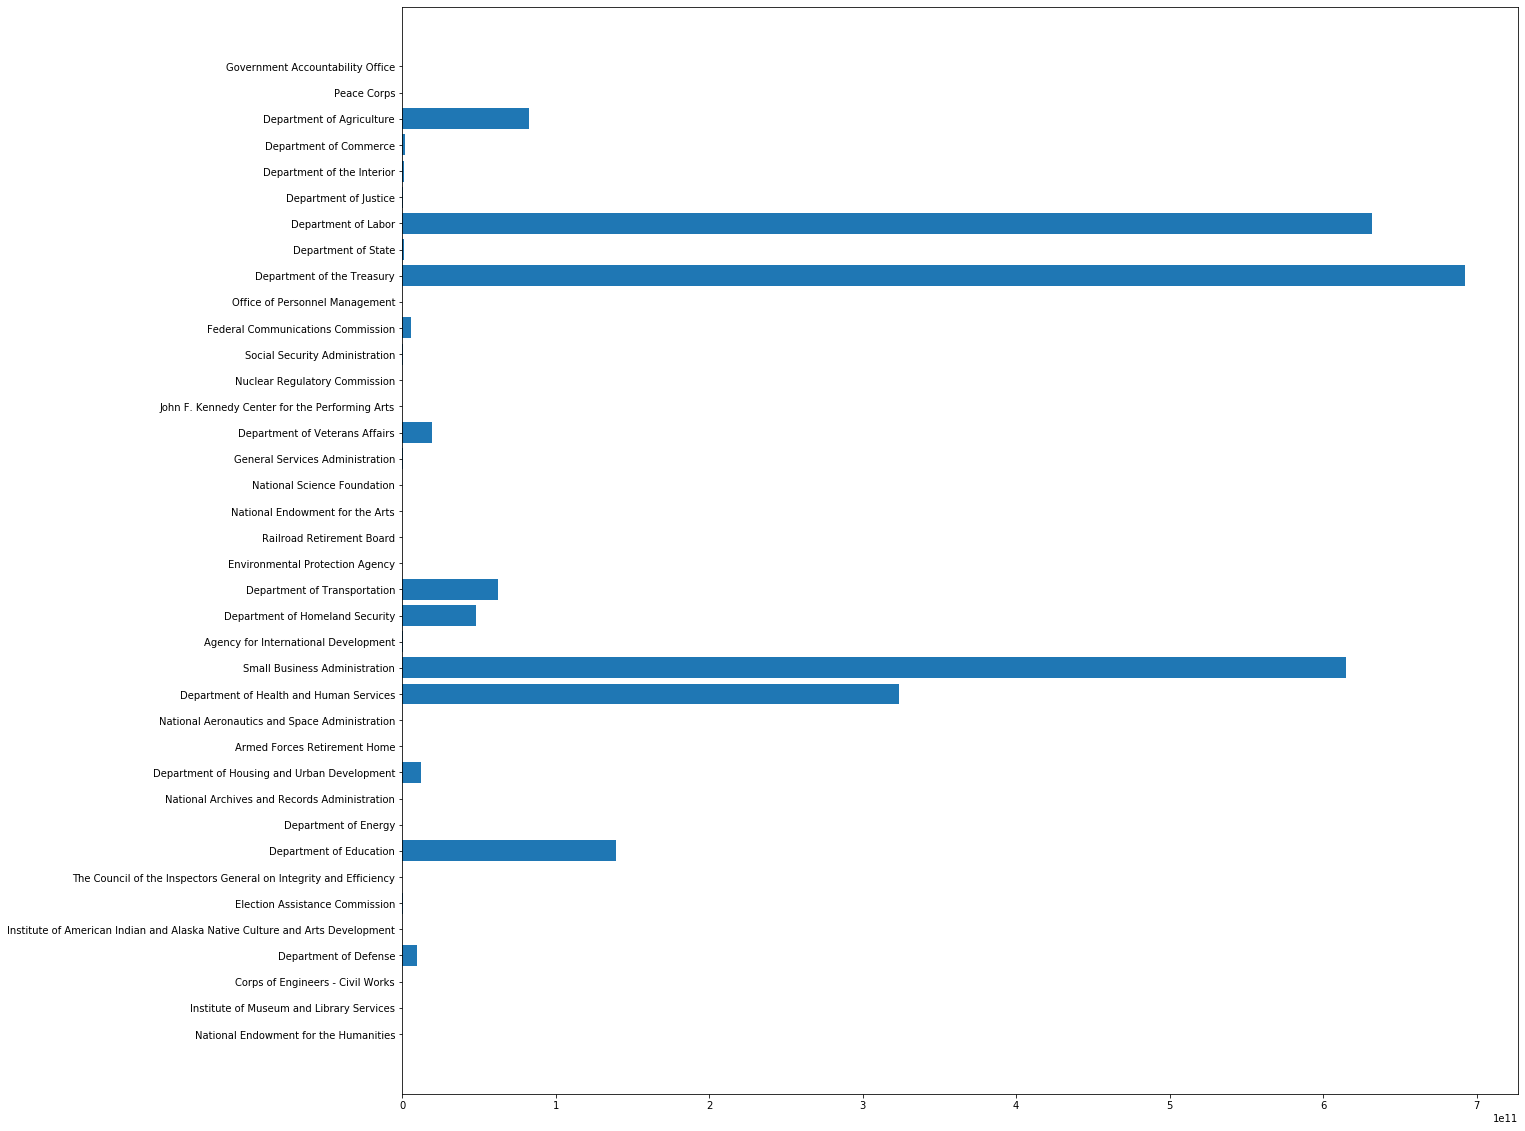

In [85]:
labels = [i['description'] for i in response]
awards = [i['total_budgetary_resources'] for i in response]

plt.figure(figsize=(20,20))
plt.barh(labels,awards)
#plt.xticks(rotation=90)


([<matplotlib.patches.Wedge at 0x7fd9be99ac90>,
 [Text(1.0999999956542885, 9.777814472344305e-05, 'National Endowment for the Humanities'),
  Text(1.0999999690971622, 0.0002607417150688407, 'Institute of Museum and Library Services'),
  Text(1.0999999208887372, 0.0004171867355012347, 'Corps of Engineers - Civil Works'),
  Text(1.0999245688812878, 0.01288187763152339, 'Department of Defense'),
  Text(1.0997100738676546, 0.025253780588218255, 'Institute of American Indian and Alaska Native Culture and Arts Development'),
  Text(1.0996979756993497, 0.025775225367644046, 'Election Assistance Commission'),
  Text(1.0996831344548141, 0.026400829449764986, 'The Council of the Inspectors General on Integrity and Efficiency'),
  Text(1.080405085347991, 0.20669990700094856, 'Department of Education'),
  Text(1.0317476537406303, 0.3814404003257976, 'Department of Energy'),
  Text(1.0316863384766835, 0.3816062093317853, 'National Archives and Records Administration'),
  Text(1.0259199516972388, 0.

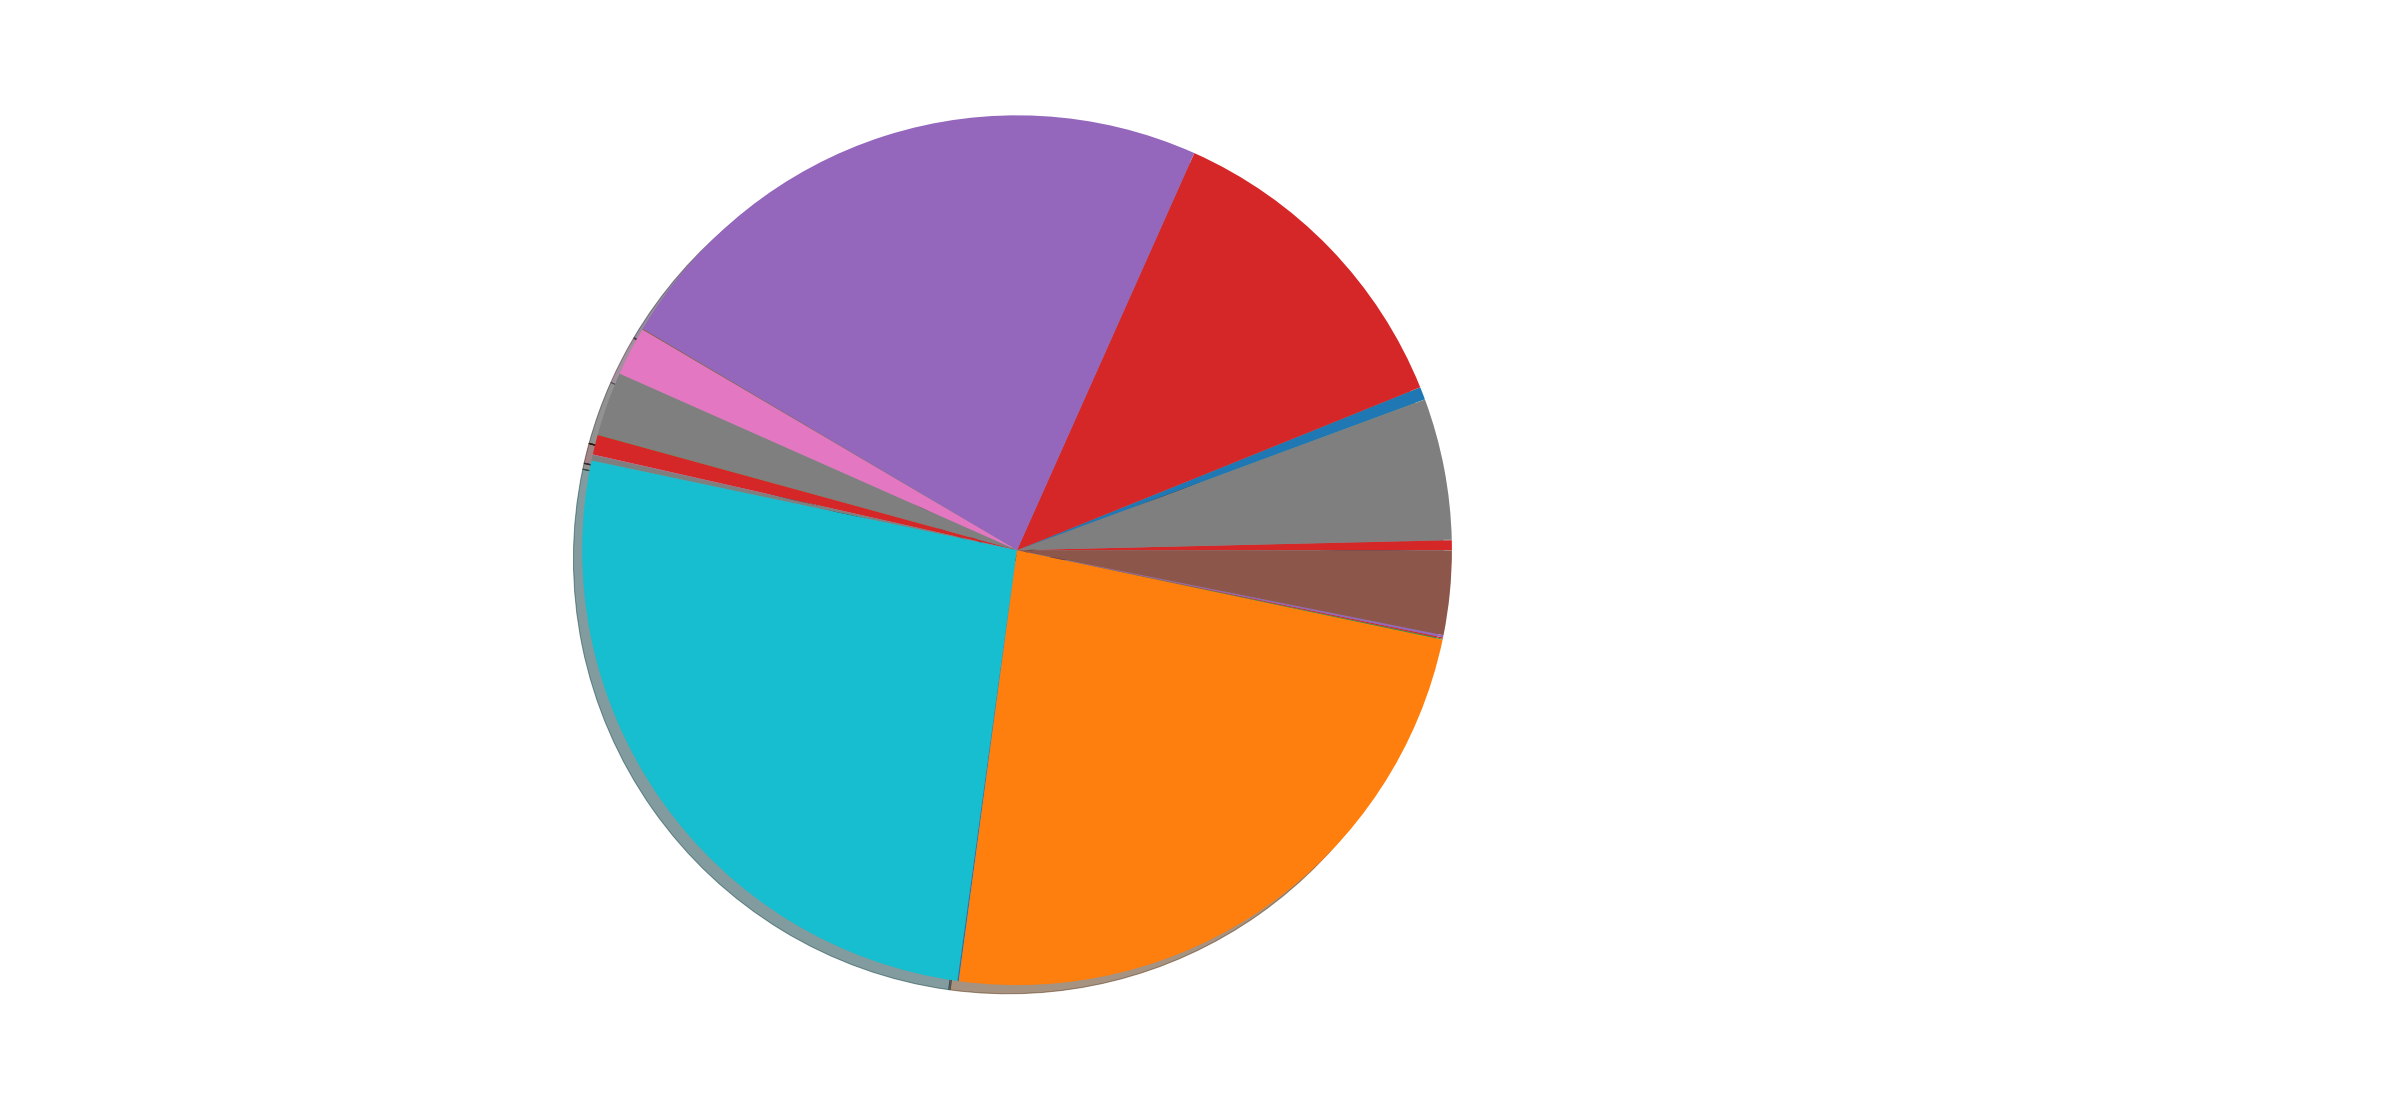

In [48]:
plt.figure(figsize=(20,20))
plt.pie(awards,labels=labels, shadow=True, textprops=dict(color="w", size=23))

In [86]:
agency_codes = [x['code'] for x in agency_dict.values()]
agency_codes

['091', '086', '075', '069', '036', '1601']

In [25]:
def geo_search_():
    
    q = '/api/v2/search/spending_by_geography/'

    # initialization
    has_next_page = True
    page = 1
    output = []

    #while has_next_page:
    payload =   {
  "filters": {
      "tas_codes": [{
          "require":[["075"]]
      }],
      "time_period":[{
          "start_date":"2020-02-06",
          "end_date":"2021-03-01"
      }]
  },

  "scope": "recipient_location",
  "geo_layer": "county"
}

    r = requests.post('https://api.usaspending.gov'+q, json=payload)
    print(r.text)
    rjson = r.json()
   # print(rjson)
    output+= rjson['results']
   # has_next_page = rjson['page_metad?ata']['hasNext']
    #page+=1
    print(r.status_code, page)
    return output

In [26]:
# With Dep Health Suffolk "aggregated_amount":19440707238.44
# With Dep Health Suffolk "aggregated_amount":172477803663.77
geo_dep_health = geo_search_()
#geo_dep_health = post_usaspending('dis_geo')


{"detail":"Invalid value in 'filters|tas_codes'. '[{'require': [['075']]}]' is not a valid type (array, object)"}


KeyError: 'results'

In [125]:

init_data = {'shape_code': [i['shape_code'] for i in geo_dep_health[:]],
 'aggregated_amount': [i['aggregated_amount'] for i in geo_dep_health[:]],
 'display_name': [i['display_name'] for i in geo_dep_health[:]],
 'population': [i['population'] for i in geo_dep_health[:]],
 'per_capita': [i['per_capita'] for i in geo_dep_health[:]]}#,
 #'award_count': [i['award_count'] for i in geo_dep_health[:]]}


#init_data = geo_dep_health[0]
gdh_df = pd.DataFrame(data=init_data)


#gdh_df = pd.read_json(geo_dep_health.json())

In [126]:
gdh_df.head()

,shape_code,aggregated_amount,display_name,population,per_capita
0,01073,1.656807e+08,Jefferson,658573.0,251.58
1,48029,2.823625e+08,Bexar,2003554.0,140.93
2,18057,9.434972e+07,Hamilton,338011.0,279.13
3,24033,2.558395e+08,Prince George'S,909327.0,281.35
4,47037,9.238053e+07,Davidson,694144.0,133.09


In [13]:
### This cell has a working date filter, and apparently a useless TAS code filter
gdh_df.head()

,shape_code,aggregated_amount,display_name,population,per_capita
0,06037,1.203893e+11,Los Angeles,10039107.0,11992.03
1,12086,2.819816e+10,Miami-Dade,2716940.0,10378.65
2,17031,6.206278e+10,Cook,5150233.0,12050.48
3,06059,3.144932e+10,Orange,3175692.0,9903.14
4,17097,8.523876e+09,Lake,696535.0,12237.54


In [52]:
for i in gdh_df.columns[:21]:
    plt.scatter(np.log(gdh_df[i]), np.log(gdh_df['per_capita']))
    plt.title(i)
    plt.show()

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log method

Index(['Unnamed: 0', 'employed people with 16 yrs and over',
       'unemployed people with 16 yrs and over', 'people in the labor force',
       'unemployment rate', 'people with private health insurance',
       'people with public health insurance',
       'people without health insurance', 'people with a disability', 'male',
       'female', 'people that are older than 65', 'median household income',
       'median age', 'white', 'black or african american',
       'american indian and alaska native', 'asian',
       'native hawaiian and other pacific islander', 'hispanic or latino',
       'other races', 'county_name', 'State', 'tot', 'countyFIPS', 'StateFIPS',
       '2021-03-21', 'amount', 'shape_code', 'population', 'per_capita',
       'award_count'],
      dtype='object')


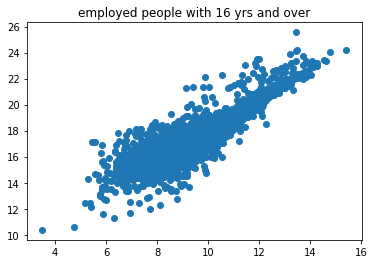

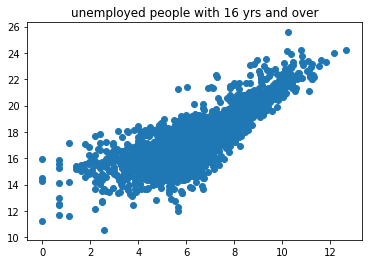

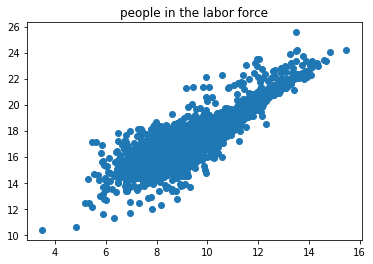

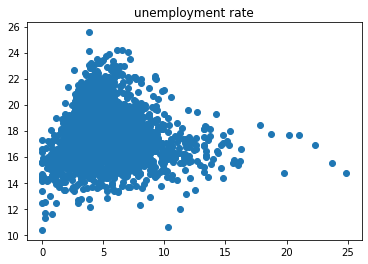

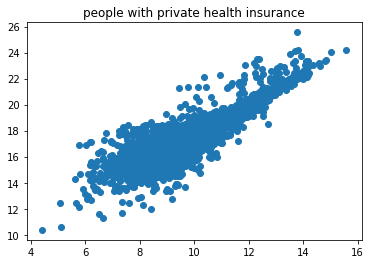

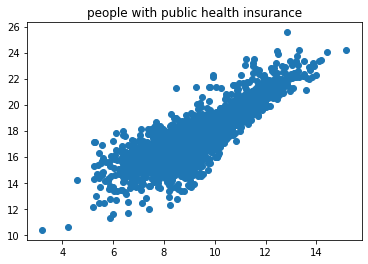

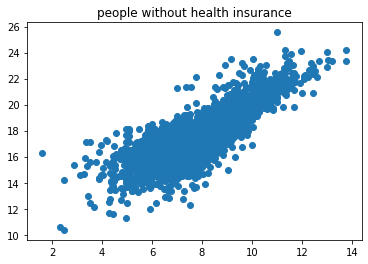

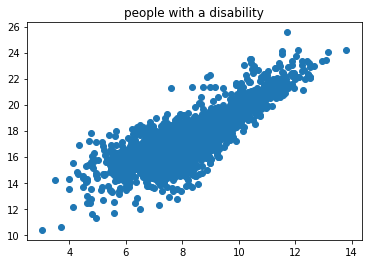

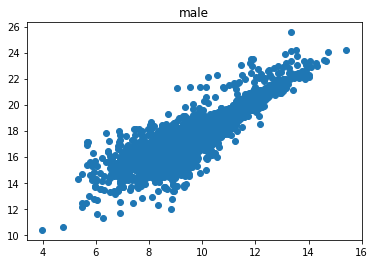

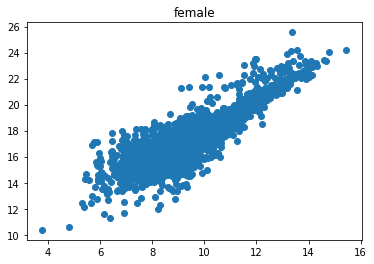

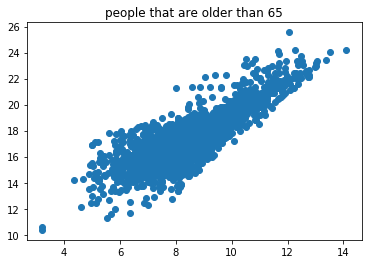

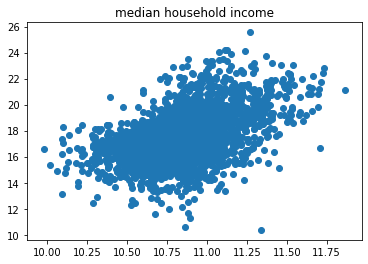

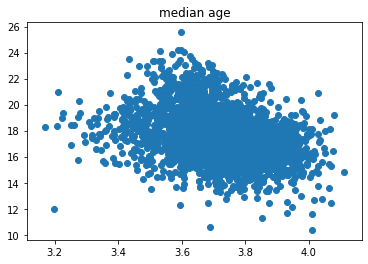

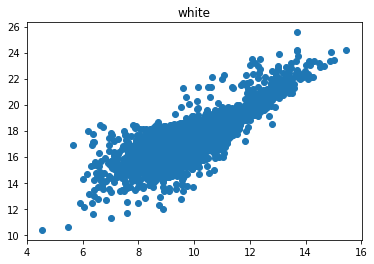

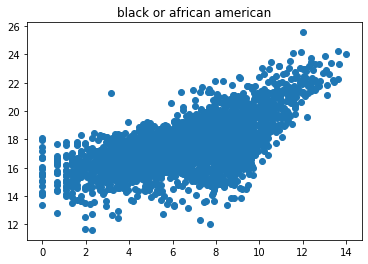

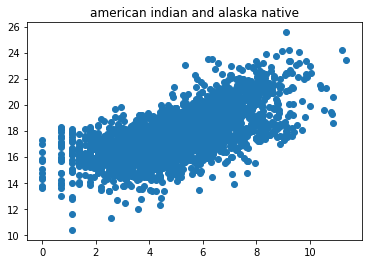

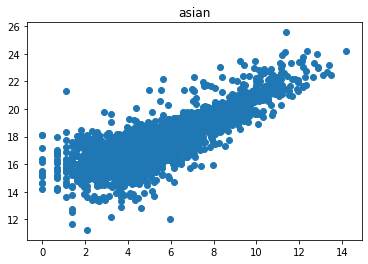

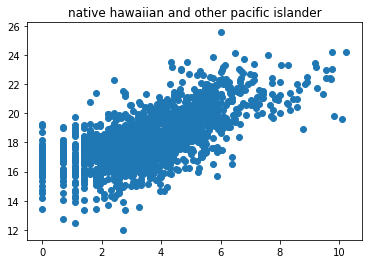

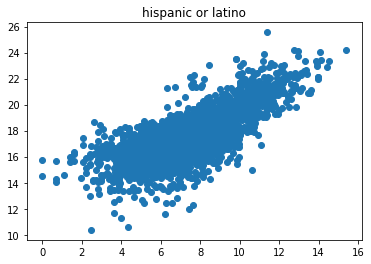

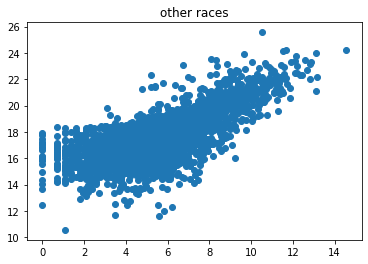

In [28]:
merged = pd.read_csv('merged_df.csv')
print(merged.columns)
for i in merged.columns[1:21]:
    if i == 'unemployment rate':
        plt.scatter(merged[i], np.log(merged['amount']))
        plt.title(i)
        plt.show()
    else:
        plt.scatter(np.log(merged[i]), np.log(merged['amount']))
        plt.title(i)
        plt.show()

In [43]:

def spend_county_state_map(spending, ACS, covid):
    spend = copy.deepcopy(spending)
    spend['State'] = ''
    val_count = spend['county_name'].value_counts()
    dupes = [i for i in val_count.index if val_count[i]!=1]
    for idx in spend.index:
        if spend.loc[idx, 'county_name'] in dupes:
            # Get a subset of the ACS data that matches entry county name
            ACS_sub = ACS[ACS['county_name']==spend.loc[idx, 'county_name']][['county_name','tot','State']]
            # calculate the difference between spend entry and ACS populations
            ACS_sub['diffs'] = np.abs(spend.loc[idx, 'population']-ACS_sub['tot'])
            # assign the lowest difference to the spending df
            #try:
            spend.loc[idx,'State']= ACS_sub[ACS_sub['diffs']==min(ACS_sub['diffs'])]['State'].values[0]
            #except:
                #spend.loc[idx,'State']= 'Missing'
                
            # Current implementation allows for multiple entries of the same county into different records
            # in the spending df which is impossible. Consider implementing a low pass filter with the
            # alternative case being unknown or a counter for number of assignments
            
        else:
            val = spend['county_name'][idx]
            #print(val)
            #print(covid[covid['county_name']==val].State.values[0])
            #print(spend.head())
           # try:
            spend.loc[idx, 'State'] = covid[covid['county_name']==val].State.values[0]
           # except:
                #spend.loc[idx, 'State'] = 'Missing'
    
    return spend


In [44]:
test = spend_county_state_map(county_spending, ACS_data, covid_cases)

NameError: name 'county_spending' is not defined